# **CNN Model**

Step-1 Loading Dataset from zip file

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/signatures.zip"
extract_to = "/content/signs_dataset"

# Extract only if not already done
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

print("Extracted successfully to:", extract_to)

Extracted successfully to: /content/signs_dataset


Step-2 Implementiing Preprocessing techniques for CNN model

i)Remove Lines

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def remove_borders(img):

  #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Threshold
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Detect horizontal lines
  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
  detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

  # Detect vertical lines
  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
  detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

  # Combine line masks
  lines = cv2.add(detect_horizontal, detect_vertical)

  # Inpaint to remove lines
  result = cv2.inpaint(img, lines, 3, cv2.INPAINT_TELEA)

  # Save output
  cv2.imwrite("output_no_lines.png", result)

  return result

ii)  Binarization and Noise Removal

In [6]:
import numpy as np
import cv2

def binarize_and_denoise(image):
    # Apply a Gaussian blur to remove noise
    denoised_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Use Otsu's thresholding to binarize the image
    _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the image if needed (to have the signature in white on a black background)
    # The paper's feature extraction might work better with this format
    inverted_image = cv2.bitwise_not(binarized_image)

    return inverted_image

iii) Scaling

In [7]:
def scale_signature(image):
    """
    Scale down signature if it occupies more than 80% of the image width.
    After scaling, center it on a canvas of original size to avoid cropping.
    """
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    if w > image.shape[1] * 0.6 or h > image.shape[0] * 0.6:
        scale_factor = 1 / math.sqrt(2)
        scaled_w = int(image.shape[1] * scale_factor)
        scaled_h = int(image.shape[0] * scale_factor)

        # Resize the image
        scaled = cv2.resize(image, (scaled_w, scaled_h), interpolation=cv2.INTER_AREA)

        # Create a blank canvas of original size
        canvas = np.zeros_like(image) * 255

        # Compute top-left corner to center the scaled image
        start_x = (canvas.shape[1] - scaled_w) // 2
        start_y = (canvas.shape[0] - scaled_h) // 2

        # Place the scaled image onto the canvas
        canvas[start_y:start_y+scaled_h, start_x:start_x+scaled_w] = scaled
        return canvas

    return image

iv) Centralization

In [8]:
import cv2
import numpy as np

def center_signature(image):
    # Find contours
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Take top 3 largest contours
    top_contours = contours[:2]

    # Combine them into one mask
    mask = np.zeros_like(image)
    cv2.drawContours(mask, top_contours, -1, (255), thickness=cv2.FILLED)

    # Get bounding box of combined contours
    x, y, w, h = cv2.boundingRect(mask)

    # Create new blank canvas
    canvas = np.zeros_like(image) * 255

    # Center coordinates
    center_x = image.shape[1] // 2
    center_y = image.shape[0] // 2

    # Calculate new top-left corner for centering
    new_x = center_x - w // 2
    new_y = center_y - h // 2

    # Place the combined contour area on the centered canvas
    canvas[new_y:new_y+h, new_x:new_x+w] = image[y:y+h, x:x+w]

    return canvas

v) Rotation

In [9]:
import cv2
import numpy as np

def rotate_signature(image, angle_threshold=5):
    """
    Rotate signatures to horizontal without flipping upside down.
    Works for both tilted and vertical cases.
    """
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image

    # Filter out very thin/long contours
    contours = [c for c in contours if cv2.boundingRect(c)[2] > 5 and cv2.boundingRect(c)[3] > 5]
    if not contours:
        return image

    # Get largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    pts = largest_contour.reshape(-1, 2).astype(np.float32)

    # PCA to find main orientation
    mean, eigenvectors = cv2.PCACompute(pts, mean=None)[:2]
    angle = np.degrees(np.arctan2(eigenvectors[0,1], eigenvectors[0,0]))

    # Skip tiny rotations
    if abs(angle) < angle_threshold:
        return image

    # Normalize angle to (-90, 90)
    if angle < -90:
        angle += 180
    elif angle > 90:
        angle -= 180

    # Rotate image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)

    return rotated


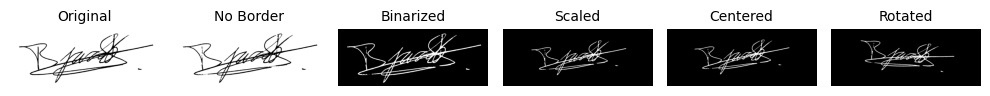

In [10]:
import cv2
import math
import matplotlib.pyplot as plt

# Load image
img_path = "/content/signs_dataset/signatures/029/09201092.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Process steps
border_removed = remove_borders(img)
binarized_img = binarize_and_denoise(border_removed)
scaled_img = scale_signature(binarized_img)
centered_img = center_signature(scaled_img)
rotated_img = rotate_signature(centered_img)

# List of images and titles
images = [img,border_removed, binarized_img,scaled_img, centered_img, rotated_img]
titles = ["Original", "No Border", "Binarized","Scaled", "Centered", "Rotated"]

# Plot in horizontal line
plt.figure(figsize=(10, 4))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(image, cmap='gray')
    plt.title(title, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


Step - 3 Aligning all preprocessing steps

In [11]:
import cv2
import numpy as np

def preprocess_pipeline(image_path, target_size=(100, 100)):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None: return np.zeros(target_size, dtype=np.uint8)

    # Apply preprocessing steps
    image = remove_borders(image)
    image = binarize_and_denoise(image)
    image = scale_signature(image)
    image = center_signature(image)
    image = rotate_signature(image)

    # Final binarization and inversion (as a safety measure)
    #_, binary_final = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Resize to target size after all other preprocessing
    final_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)


    return final_image

Step-4 Creating Dataset Class

In [12]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
import glob

In [13]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

# Make sure all your preprocessing functions (preprocess_pipeline, remove_noise, etc.)
# are defined and available in your notebook environment.

class SignatureDataset(Dataset):
    def __init__(self, image_paths, signer_ids, is_genuine_labels):
        self.image_paths = image_paths
        self.signer_ids = signer_ids
        self.is_genuine_labels = is_genuine_labels

        # Create a mapping for signer IDs to integer indices
        unique_signer_ids = sorted(list(set(signer_ids)))
        self.signer_id_map = {name: i for i, name in enumerate(unique_signer_ids)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Load image and apply the full preprocessing pipeline
        # (This assumes preprocess_pipeline is a single function that
        # orchestrates your other preprocessing functions)
        image = preprocess_pipeline(img_path)

        # Convert to float, normalize, and add a channel dimension
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0) # PyTorch expects [C, H, W]

        # Convert to a PyTorch tensor
        image_tensor = torch.from_numpy(image)

        # Get labels and convert to PyTorch tensors
        signer_id_label = self.signer_id_map[self.signer_ids[idx]]
        signer_id_tensor = torch.tensor(signer_id_label, dtype=torch.long)

        genuine_label = self.is_genuine_labels[idx]
        genuine_tensor = torch.tensor(genuine_label, dtype=torch.long)

        # Return the preprocessed image and both labels
        return image_tensor, signer_id_tensor, genuine_tensor

Step-5 Loading the dataset

In [14]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import glob
import os
import numpy as np
import cv2
import math

In [15]:

# Base directory where your data is extracted
base_dir = "/content/signs_dataset"
data_dir = os.path.join(base_dir, "signatures")

# Lists to store image paths, signer IDs, and forgery labels
image_paths = []
signer_ids = []
is_genuine = []

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        # Determine the signer ID and genuine flag from the folder name
        if "_forg" in folder_name:
            signer_id = folder_name.replace("_forg", "")
            genuine_flag = 0  # 0 for forged
        else:
            signer_id = folder_name
            genuine_flag = 1  # 1 for genuine

        for file_name in os.listdir(folder_path):
            if file_name.endswith(('.png', '.jpg', '.jpeg', '.PNG')):
                image_paths.append(os.path.join(folder_path, file_name))
                signer_ids.append(signer_id)
                is_genuine.append(genuine_flag)


train_dataset = SignatureDataset(image_paths, signer_ids, is_genuine)

# Create DataLoader objects
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Data loading is complete.")
print(f"Number of training batches: {len(train_loader)}")

Data loading is complete.
Number of training batches: 10


Display

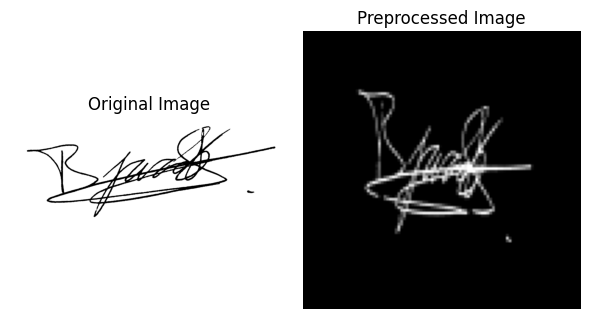

In [17]:
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(image_paths))
random_image_path = image_paths[random_index]

# 1. Load the original image
original_image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)

# 2. Apply the preprocessing pipeline
preprocessed_image = preprocess_pipeline(random_image_path)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

# Original Image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')

axes[0].axis('off') # Hide the axes

# Preprocessed Image
axes[1].imshow(preprocessed_image, cmap='gray')
axes[1].set_title('Preprocessed Image')
axes[1].axis('off') # Hide the axes

plt.tight_layout()
plt.show()

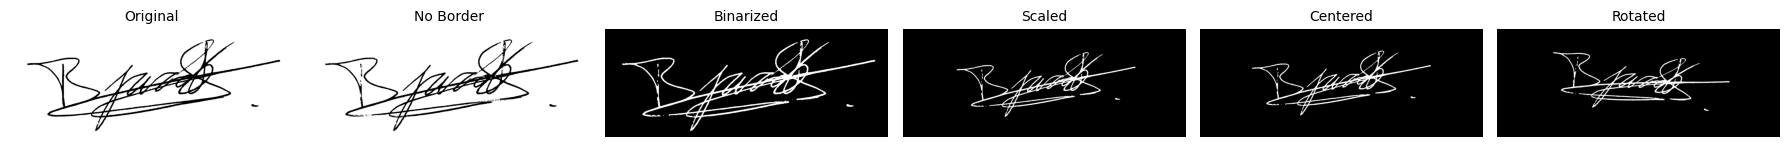

In [18]:
import cv2
import matplotlib.pyplot as plt

# Load image
img_path = image_paths[random_index]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Process steps
border_removed = remove_borders(img)
binarized_img = binarize_and_denoise(border_removed)
scaled_img = scale_signature(binarized_img)
centered_img = center_signature(scaled_img)
rotated_img = rotate_signature(centered_img)

# List of images and titles
images = [img,border_removed, binarized_img,scaled_img, centered_img, rotated_img]
titles = ["Original", "No Border", "Binarized","Scaled", "Centered", "Rotated"]

# Plot in horizontal line
plt.figure(figsize=(18, 6))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(image, cmap='gray')
    plt.title(title, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


Step-6 : Creating a CNN Model

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

class SignatureResNet(nn.Module):
    def __init__(self, num_classes):
        super(SignatureResNet, self).__init__()

        # Load pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)

        # Modify first conv layer to accept 1-channel grayscale input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final fully connected layer with custom classifier
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

Step-7 Training the Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
num_classes = len(train_dataset.signer_id_map)
model = SignatureResNet(num_classes=num_classes).to(device)

# Weight Initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Save Path
save_dir = "/content/drive/MyDrive/new_saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "signature_cnn_best.pth")

# Training Loop with Early Stopping
num_epochs = 100
patience = 10
best_acc = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for images, signer_labels, _ in train_loader:
        images, signer_labels = images.to(device), signer_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, signer_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(signer_labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    avg_train_loss = train_loss / len(train_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Check for improvement
    if train_acc > best_acc:
        best_acc = train_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved at epoch {epoch+1} with acc: {train_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Epoch [1/100] Train Loss: 4.6444 | Train Acc: 0.0433
Best model saved at epoch 1 with acc: 0.0433
Epoch [2/100] Train Loss: 3.9122 | Train Acc: 0.0600
Best model saved at epoch 2 with acc: 0.0600
Epoch [3/100] Train Loss: 4.2791 | Train Acc: 0.0667
Best model saved at epoch 3 with acc: 0.0667
Epoch [4/100] Train Loss: 3.8984 | Train Acc: 0.0400
No improvement for 1 epoch(s)
Epoch [5/100] Train Loss: 3.7646 | Train Acc: 0.0467
No improvement for 2 epoch(s)
Epoch [6/100] Train Loss: 3.5700 | Train Acc: 0.0600
No improvement for 3 epoch(s)
Epoch [7/100] Train Loss: 3.3832 | Train Acc: 0.0900
Best model saved at epoch 7 with acc: 0.0900
Epoch [8/100] Train Loss: 3.5838 | Train Acc: 0.0733
No improvement for 1 epoch(s)
Epoch [9/100] Train Loss: 3.2240 | Train Acc: 0.0800
No improvement for 2 epoch(s)
Epoch [10/100] Train Loss: 3.1917 | Train Acc: 0.0900
No improvement for 3 epoch(s)
Epoch [11/100] Train Loss: 3.0960 | Train Acc: 0.1033
Best model saved at epoch 11 with acc: 0.1033
Epoch [12

Testing

In [20]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
num_classes = len(train_dataset.signer_id_map)
model = SignatureResNet(num_classes=num_classes).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [21]:
model_path = "/content/drive/MyDrive/new_saved_models/signature_cnn_best.pth"

In [22]:
import torch
from sklearn.metrics import accuracy_score

# Load the best saved model
model.load_state_dict(torch.load(model_path))
model.eval()

# Move model to device
model.to(device)

# Evaluation loop
test_preds = []
test_labels = []

with torch.no_grad():
    for images, signer_labels, _ in train_loader:  # Reusing train_loader
        images = images.to(device)
        signer_labels = signer_labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(signer_labels.cpu().numpy())

# Compute accuracy
test_acc = accuracy_score(test_labels, test_preds)
print(f" Evaluation Accuracy on Training Data: {test_acc:.4f}")


 Evaluation Accuracy on Training Data: 0.9633


Testing by giving and input signature

In [23]:
signer_id_map = train_dataset.signer_id_map

In [24]:
reverse_map = {v: k for k, v in signer_id_map.items()}

In [25]:
print(train_dataset.signer_id_map)

{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29}


In [26]:
print(reverse_map)

{0: '001', 1: '002', 2: '003', 3: '004', 4: '005', 5: '006', 6: '007', 7: '008', 8: '009', 9: '010', 10: '011', 11: '012', 12: '013', 13: '014', 14: '015', 15: '016', 16: '017', 17: '018', 18: '019', 19: '020', 20: '021', 21: '022', 22: '023', 23: '024', 24: '025', 25: '026', 26: '027', 27: '028', 28: '029', 29: '030'}


In [27]:
model = SignatureResNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [28]:
def predict_signer(image_path):
    # Load and preprocess the image
    image = preprocess_pipeline(image_path)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # [1, H, W] → channel dimension
    image = np.expand_dims(image, axis=0)  # [1, 1, H, W] → batch dimension

    image_tensor = torch.from_numpy(image).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_id = output.argmax(1).item()

    #print(f"Predicted Signer ID: {predicted_id}")
    return predicted_id

In [29]:
model = SignatureResNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

SignatureResNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [30]:
image_path = "/content/signs_dataset/signatures/002_forg/02102002.png"
predicted_id = predict_signer(image_path)
print(predicted_id)

1


In [31]:
predicted_signer_name = reverse_map[predicted_id]
print(f"🖋️ Predicted Signer ID: {predicted_id}")
print(f"🔍 Predicted Signer Name: {predicted_signer_name}")

🖋️ Predicted Signer ID: 1
🔍 Predicted Signer Name: 002


# **Detection**

getting the embeddings

In [32]:
import torch.nn.functional as F
import os

def get_embedding(image_path):
    image = preprocess_pipeline(image_path)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # [1, H, W]
    image = np.expand_dims(image, axis=0)  # [1, 1, H, W]
    image_tensor = torch.from_numpy(image).to(device)

    with torch.no_grad():
        features = model.base_model.avgpool(model.base_model.layer4(model.base_model.layer3(
            model.base_model.layer2(model.base_model.layer1(model.base_model.relu(
                model.base_model.bn1(model.base_model.conv1(image_tensor))))))))
        embedding = features.view(features.size(0), -1)  # Flatten
    return embedding.squeeze(0)  # Remove batch dimension

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def verify_signature(input_path, signer_id):
    base_path = "/content/signs_dataset/signatures"
    genuine_folder = os.path.join(base_path, signer_id)
    forged_folder = os.path.join(base_path, signer_id + "_forg")

    input_embedding = get_embedding(input_path)

    genuine_scores = []
    forged_scores = []

    # Compare with genuine samples
    for fname in os.listdir(genuine_folder):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            emb = get_embedding(os.path.join(genuine_folder, fname))
            score = cosine_similarity([input_embedding.cpu().numpy()], [emb.cpu().numpy()])[0][0]
            genuine_scores.append(score)

    # Compare with forged samples
    for fname in os.listdir(forged_folder):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            emb = get_embedding(os.path.join(forged_folder, fname))
            score = cosine_similarity([input_embedding.cpu().numpy()], [emb.cpu().numpy()])[0][0]
            forged_scores.append(score)

    avg_genuine = np.mean(genuine_scores)
    avg_forged = np.mean(forged_scores)

    #print(f"Avg Genuine Similarity: {avg_genuine:.4f}")
    #print(f"Avg Forged Similarity: {avg_forged:.4f}")

    if avg_genuine > avg_forged:
        #print("Prediction: Signature is likely GENUINE")
        return True, avg_genuine, avg_forged
    else:
        #print("Prediction: Signature is likely FORGED")
        return False, avg_genuine, avg_forged



In [34]:
is_real = verify_signature(image_path, predicted_signer_name)

For New User verification

In [35]:
# Verification method
def verify_signature_test(genuine_paths, test_path, threshold=0.9):
    genuine_embeddings = [get_embedding(path) for path in genuine_paths]
    test_embedding = get_embedding(test_path)

    similarities = [
        F.cosine_similarity(test_embedding.unsqueeze(0), g.unsqueeze(0)).item()
        for g in genuine_embeddings
    ]
    avg_similarity = sum(similarities) / len(similarities)

    result = "Genuine" if avg_similarity > threshold else "Forged"
    return result, avg_similarity

In [41]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import tempfile
import os

# Widgets
mode_selector = widgets.ToggleButtons(options=["Existing User", "New User"], description="Mode:")
existing_upload = widgets.FileUpload(accept='.png,.jpg,.jpeg', description="Upload Test Sign", multiple=False)
new_genuine_upload = widgets.FileUpload(accept='.png,.jpg,.jpeg', description="Genuine Signs-5+", multiple=True)
new_test_upload = widgets.FileUpload(accept='.png,.jpg,.jpeg', description="Upload Test Sign", multiple=False)
verify_button = widgets.Button(description="Verify", button_style='success')
output = widgets.Output()

# Helper to save uploaded bytes to temp file
def save_temp_file(file_bytes, suffix=".png"):
    temp = tempfile.NamedTemporaryFile(delete=False, suffix=suffix)
    temp.write(file_bytes)
    temp.close()
    return temp.name

# 🧹 Helper to reset widgets
def reset_widgets():
    existing_upload.value.clear()
    new_genuine_upload.value.clear()
    new_test_upload.value.clear()
    existing_upload._counter = 0
    new_genuine_upload._counter = 0
    new_test_upload._counter = 0

# Main logic
def on_verify_clicked(b):
    output.clear_output()
    mode = mode_selector.value

    with output:
        if mode == "Existing User":
            if not existing_upload.value:
                print("Upload a test signature.")
                return
            test_bytes = list(existing_upload.value.values())[0]['content']
            test_path = save_temp_file(test_bytes)

            predicted_id = predict_signer(test_path)
            predicted_name = reverse_map[predicted_id]
            print(f"Predicted Signer ID: {predicted_id}")
            print(f"Predicted ID: {predicted_id}")
            print(f"Predicted Name: {predicted_name}")

            is_real, gen_sim, forg_sim = verify_signature(test_path, predicted_name)
            print(f"Avg Genuine Similarity: {gen_sim:.4f}")
            print(f"Avg Forged Similarity: {forg_sim:.4f}")
            print(f"Prediction: Signature is likely {'GENUINE' if is_real else 'FORGED'}")
            print(f"Result: {'Genuine ✅' if is_real else 'Forged ❌'}")

            os.remove(test_path)

        else:  # New User
            if len(new_genuine_upload.value) < 5:
                print("Upload at least 5 genuine samples.")
                return
            if not new_test_upload.value:
                print("Upload a test signature.")
                return

            genuine_paths = [save_temp_file(file['content']) for file in new_genuine_upload.value.values()]
            test_bytes = list(new_test_upload.value.values())[0]['content']
            test_path = save_temp_file(test_bytes)

            result, avg_sim = verify_signature_test(genuine_paths, test_path)
            print(f"Similarity: {avg_sim:.4f}")
            print(f"Result: {result} {'✅' if result == 'Genuine' else '❌'}")

            for path in genuine_paths:
                os.remove(path)
            os.remove(test_path)

        reset_widgets()
        print("\n✅ Verification complete. Ready for next input.")


verify_button.on_click(on_verify_clicked)

# 🔄 Dynamic visibility
def update_visibility(change):
    if change['new'] == "Existing User":
        existing_upload.layout.display = 'block'
        new_genuine_upload.layout.display = 'none'
        new_test_upload.layout.display = 'none'
    else:
        existing_upload.layout.display = 'none'
        new_genuine_upload.layout.display = 'block'
        new_test_upload.layout.display = 'block'

mode_selector.observe(update_visibility, names='value')
update_visibility({'new': mode_selector.value})  # Initial setup

# 📦 Display interface
display(widgets.VBox([
    mode_selector,
    existing_upload,
    new_genuine_upload,
    new_test_upload,
    verify_button,
    output
]))

In [46]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook --inplace /content/*.ipynb

[NbConvertApp] WARNING | pattern '/content/*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    